# Seismic Windows Detection

In [12]:
# Import libraries
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
from scipy import signal
from matplotlib import cm
import random
from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset
import librosa
import librosa.display
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import itertools
import glob

### Preparing Data

In [13]:
def filter_data(data, min_freq, max_freq):
    data.filter('lowpass',freq=max_freq)
    data.filter('highpass',freq=min_freq)
    return data

In [14]:
def get_data_from_mseed(training_path, csv_file, min_freq, max_freq):
    mseed_files = glob.glob(os.path.join(training_path, "*.mseed"))
    data_list = []
    target_df = pd.read_csv(csv_file)

    for mseed_file in mseed_files:
        stream = read(mseed_file)
        stream = filter_data(stream, min_freq, max_freq)
        filename = os.path.basename(mseed_file).rstrip(".mseed")
        # print(f"Processing: {filename}")
        
        if 'filename' not in target_df.columns or 'time_rel(sec)' not in target_df.columns:
            # print(f"Error: Columns 'filename' or 'time_rel(sec)' not found in target DataFrame.")
            continue
        
        target_df['filename'] = target_df['filename'].str.replace('.csv', '', regex=False)
        matching_rows = target_df[target_df['filename'] == filename]
        if matching_rows.empty:
            # print(f"Warning: No matching filename found in the target DataFrame for {filename}. Skipping this file.")
            continue

        try:
            target = matching_rows['time_rel(sec)'].iloc[0]
        except IndexError:
            # print(f"Error: No 'time_rel(sec)' value found for filename {filename}. Skipping this file.")
            continue

        for trace in stream:
            row = {
                "file_name": filename,  # File name without path
                "rel_times": trace.times(),
                "data": trace.data,
                "start_time": trace.stats.starttime,  # Absolute start time
                "end_time": trace.stats.endtime,      # Absolute end time
                "target": target,                     # Target value for the filename
                "sampling_rate": trace.stats.sampling_rate,
            }
            data_list.append(row)

    df = pd.DataFrame(data_list)
    # print("Final DataFrame:\n", df)
    return df

def get_data(training_folders, catalog_folders, min_freq=0.5, max_freq=1):
    df = pd.DataFrame()
    for training_folder, catalog_folder in zip(training_folders, catalog_folders):
        new_df = get_data_from_mseed(training_folder, catalog_folder, min_freq, max_freq)
        df = pd.concat([df, new_df], axis=0, ignore_index=True)
    print(df)
    return df

In [15]:
def get_data_from_mseed_test(test_path, min_freq, max_freq):
    mseed_files = glob.glob(os.path.join(test_path, "*.mseed"))
    data_list = []

    for mseed_file in mseed_files:
        stream = read(mseed_file)
        stream = filter_data(stream, min_freq, max_freq)
        filename = os.path.basename(mseed_file).rstrip(".mseed")
        # print(f"Processing: {filename}")

        for trace in stream:
            row = {
                "file_name": filename,  # File name without path
                "rel_times": trace.times(),
                "data": trace.data,
                "start_time": trace.stats.starttime,  # Absolute start time
                "end_time": trace.stats.endtime,      # Absolute end time
                "sampling_rate": trace.stats.sampling_rate,
            }
            data_list.append(row)

    df = pd.DataFrame(data_list)
    # print("Final DataFrame:\n", df)
    return df

def get_test_data(test_folders, min_freq=0.5, max_freq=1):
    df = pd.DataFrame()
    for test_folder in test_folders:
        new_df = get_data_from_mseed_test(test_folder, min_freq, max_freq)
        df = pd.concat([df, new_df], axis=0, ignore_index=True)
    print(df)
    return df

### Algorithm Definition

In [31]:
def find_clusters(hf_points, _min_dist = 2000):

    X = np.array(hf_points).reshape(-1, 1)  

    initial_n_clusters = 5 
    kmeans = KMeans(n_clusters=initial_n_clusters)
    kmeans.fit(X)

    centers = kmeans.cluster_centers_

    def filter_centroids(centroids, min_distance):
        filtered_centroids = []
        
        for centroid in centroids:
            if all(np.linalg.norm(centroid - other) >= min_distance for other in filtered_centroids):
                filtered_centroids.append(centroid)
        
        return np.array(filtered_centroids)

    filtered_centroids = filter_centroids(centers, _min_dist)

    return filtered_centroids



def seismic_centers_detect(tr_times, tr_data, tr_sampling_rate, _target=None, 
                        _STA=120, _LTA=600, _high_freq_thresh=0.05, _power_thresh=0.4, plot=False):
    

    act_quake_cat = _target
    local_acc = 0

    fp, t, sxx = signal.spectrogram(tr_data, tr_sampling_rate, nperseg=256, noverlap=128, scaling='density')
    vmax = sxx.max()
    vmin = sxx.min()

    # Sampling frequency of our trace
    df = tr_sampling_rate

    sta_len = _STA
    lta_len = _LTA

    # Run Obspy's STA/LTA to obtain a characteristic function
    # This function basically calculates the ratio of amplitude between the short-term 
    # and long-term windows, moving consecutively in time across the data
    cft = classic_sta_lta(tr_data, int(sta_len * df), int(lta_len * df))

    if plot:
        # Plot characteristic function
        fig, (ax, ax1 ,ax2) = plt.subplots(3, 1, figsize=(12, 8))

        ax.plot(tr_times,tr_data)
        ax.set_xlim([min(tr_times),max(tr_times)])
        ax.set_ylabel('Velocity (m/s)')
        #ax.set_xlabel('Time (s)')
        ax.set_title('Filtered')
        #ax.set_title(f'{test_filename}', fontweight='bold') 


        # Plot characteristic function
        ax1.plot(tr_times, cft)
        #ax1.set_title('Unfiltered' if f == 0 else f'Filtered - bandpass [{minfreq} {maxfreq}]')
        ax1.set_xlim([min(tr_times), max(tr_times)])
        #ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Characteristic function')
        
        #ax1.legend()

        ## Plot spectrogram
        vals = ax2.pcolormesh(t, fp, sxx, cmap=cm.jet, vmin = vmin, vmax=vmax)
        #vals = ax2.pcolormesh(t, fp, sxx, cmap=cm.jet, vmin = 0, vmax=1)

        ax2.set_xlim([min(tr_times), max(tr_times)])
        ax2.set_xlabel(f'Time (s)', fontweight='bold')
        ax2.set_ylabel('Frequency (Hz)')
        

        #cbar = plt.colorbar(vals, ax=ax2, orientation='horizontal')
        #cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold')

    if plot and _target:
        ax.axvline(x=act_quake_cat, c='red')
        ax1.axvline(x=act_quake_cat, c='red')
        ax2.axvline(x=act_quake_cat, c='red', linewidth=1)


    # Normalize fp and sxx
    fp = (fp - np.min(fp)) / (np.max(fp) - np.min(fp))
    sxx = (sxx - np.min(sxx)) / (np.max(sxx) - np.min(sxx))  

    high_freq_mask = fp >= _high_freq_thresh  # Mask for high frequencies
    high_power_mask = sxx > _power_thresh    # Mask for sections with high power
    # Combined mask for high-frequency and high-power regions
    combined_mask = np.logical_and(high_freq_mask[:, None], high_power_mask)
    # Extract high-frequency sections
    high_freq_sections = []
    for i in range(sxx.shape[1]):  # Iterate over time steps
        high_freqs_at_t = fp[combined_mask[:, i]]  # Extract frequencies for time step i
        if len(high_freqs_at_t) > 0:
            high_freq_sections.append((t[i], high_freqs_at_t))

    if len(high_freq_sections) > 0:
        hf_points = [row[0] for row in high_freq_sections]
        try:
            centers = find_clusters(hf_points)
            swd_centers = list(itertools.chain.from_iterable(centers))

            for v in swd_centers:
                if plot:
                    ax2.axvline(x=v, c='yellow', linewidth=1)
                    ax.axvline(x=v-2500, c='blue', linewidth=4)
                    ax.axvline(x=min((v+6500),(tr_times[-1]-100)), c='blue', linewidth=4)
                if _target and v-2500 <= act_quake_cat <= v+6500:
                    local_acc = 1
        except:
            print('Number of samples less than number of clusters')
            swd_centers = None

    return swd_centers, local_acc


### Accuracy Computation

In [17]:
train_data = get_data(['./data/lunar/training/data/S12_GradeA/', './data/mars/training/data/'], 
                      ['./data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv', './data/mars/training/catalogs/Mars_InSight_training_catalog_final.csv'])

test_data = get_test_data(['./data/lunar/test/data/S12_GradeB/', './data/lunar/test/data/S15_GradeA/', './data/lunar/test/data/S15_GradeB/', 
                           './data/lunar/test/data/S16_GradeA/', './data/lunar/test/data/S16_GradeB/', './data/mars/test/data/'])

                                  file_name  \
0    xa.s12.00.mhz.1970-01-19HR00_evid00002   
1    xa.s12.00.mhz.1970-03-25HR00_evid00003   
2    xa.s12.00.mhz.1970-03-26HR00_evid00004   
3    xa.s12.00.mhz.1970-04-25HR00_evid00006   
4    xa.s12.00.mhz.1970-04-26HR00_evid00007   
..                                      ...   
72   xa.s12.00.mhz.1975-05-04HR00_evid00192   
73   xa.s12.00.mhz.1975-06-24HR00_evid00196   
74   xa.s12.00.mhz.1975-06-26HR00_evid00198   
75  XB.ELYSE.02.BHV.2022-01-02HR04_evid0006   
76  XB.ELYSE.02.BHV.2022-02-03HR08_evid0005   

                                            rel_times  \
0   [0.0, 0.1509433962264151, 0.3018867924528302, ...   
1   [0.0, 0.1509433962264151, 0.3018867924528302, ...   
2   [0.0, 0.1509433962264151, 0.3018867924528302, ...   
3   [0.0, 0.1509433962264151, 0.3018867924528302, ...   
4   [0.0, 0.1509433962264151, 0.3018867924528302, ...   
..                                                ...   
72  [0.0, 0.1509433962264151, 0.3018

In [35]:
def compute_accuracy(df):
    num_rows = len(df)
    accuracy = 0
    for row in df.itertuples():
        swd_centers, tmp_acc = seismic_centers_detect(row.rel_times, row.data, row.sampling_rate, _target=row.target, 
                        _STA=120, _LTA=600, _high_freq_thresh=0.05, _power_thresh=0.4)
        accuracy += tmp_acc
    return accuracy / num_rows

print("ACCURACY:")
print(compute_accuracy(train_data))

ACCURACY:
Number of samples less than number of clusters
Number of samples less than number of clusters
Number of samples less than number of clusters
Number of samples less than number of clusters
Number of samples less than number of clusters
Number of samples less than number of clusters
0.8701298701298701


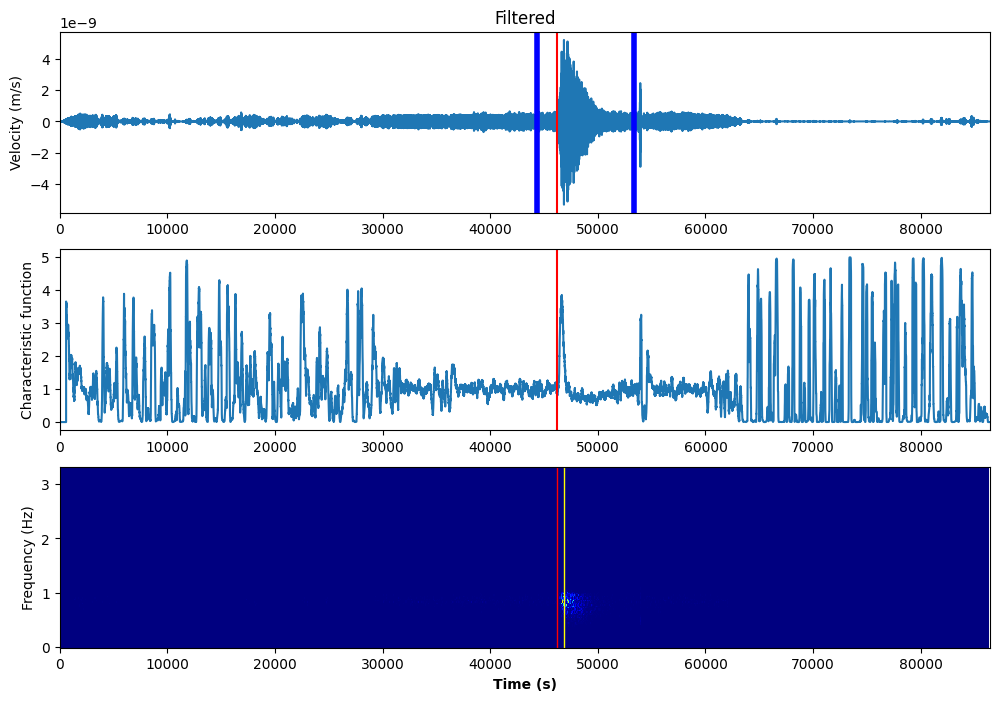

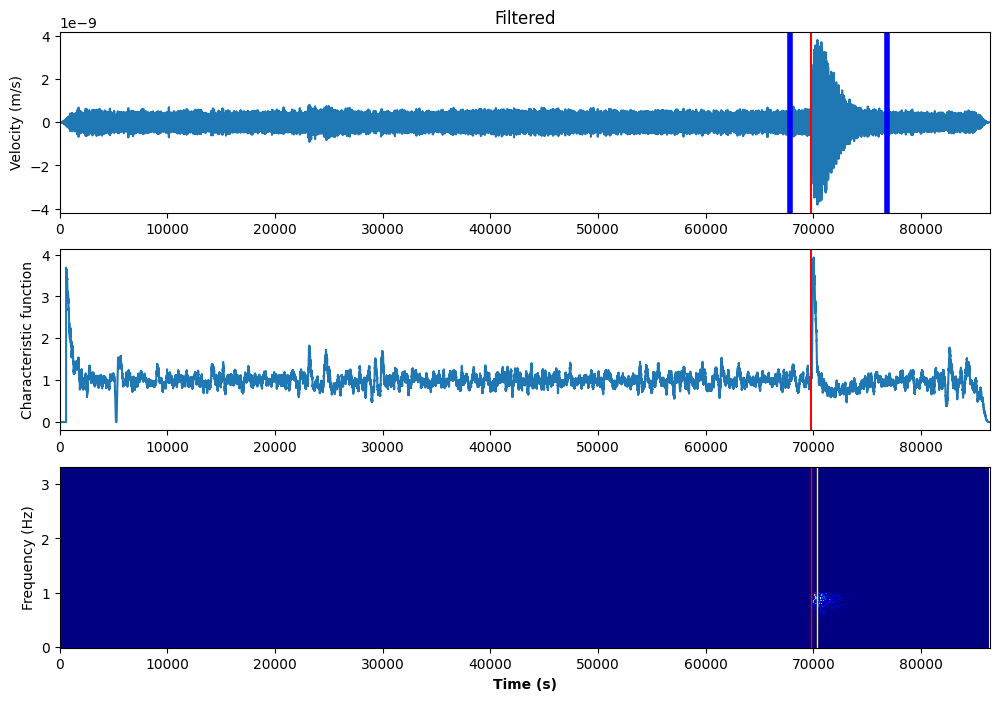

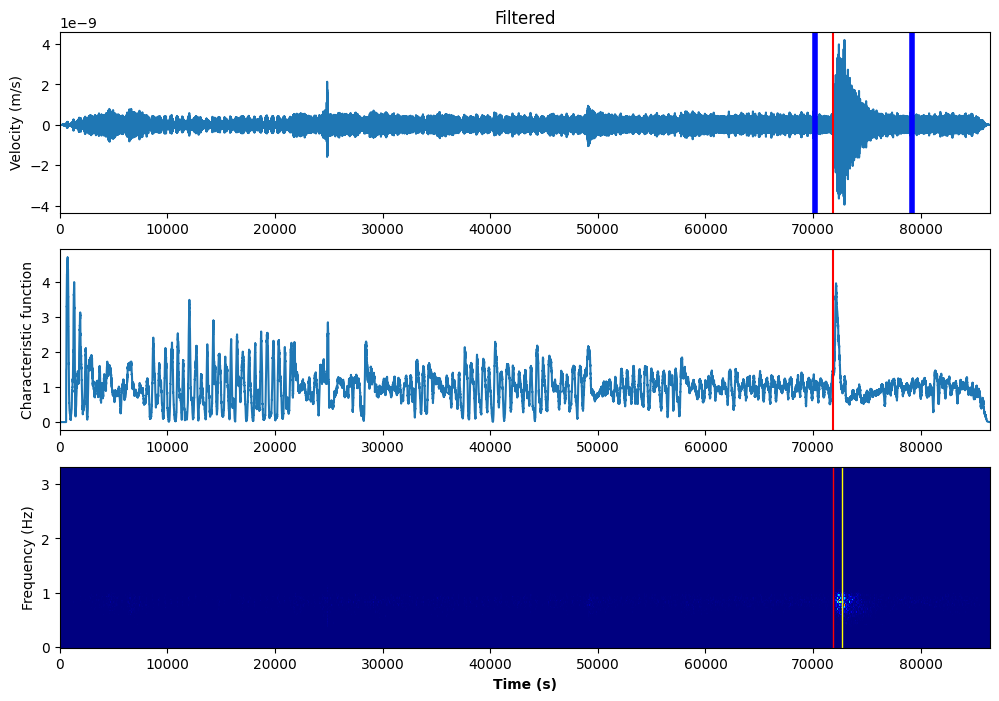

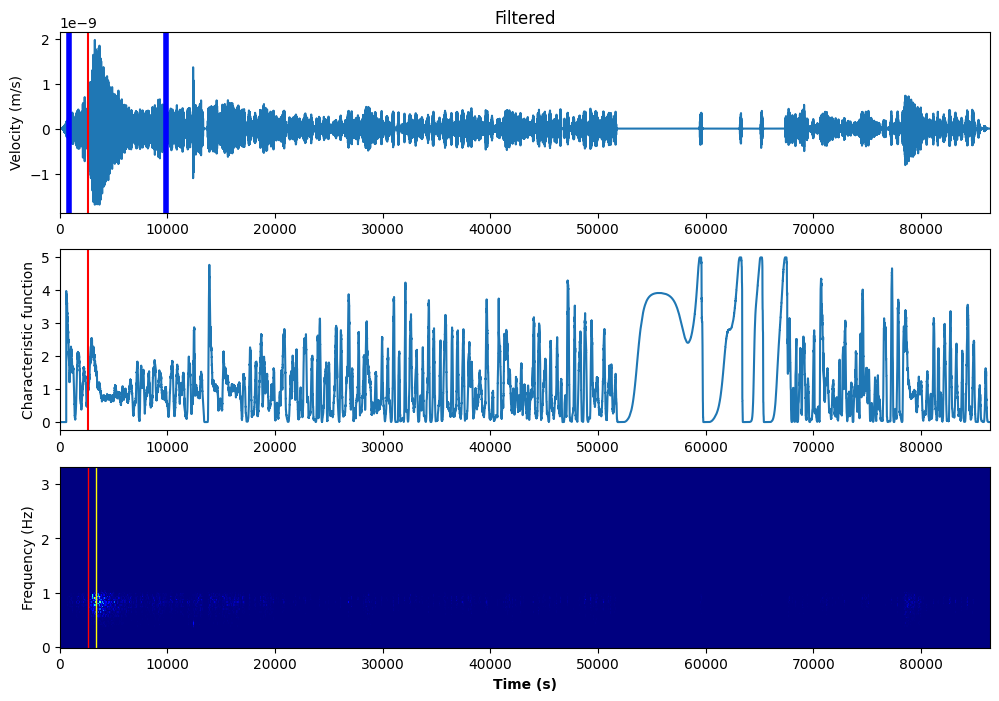

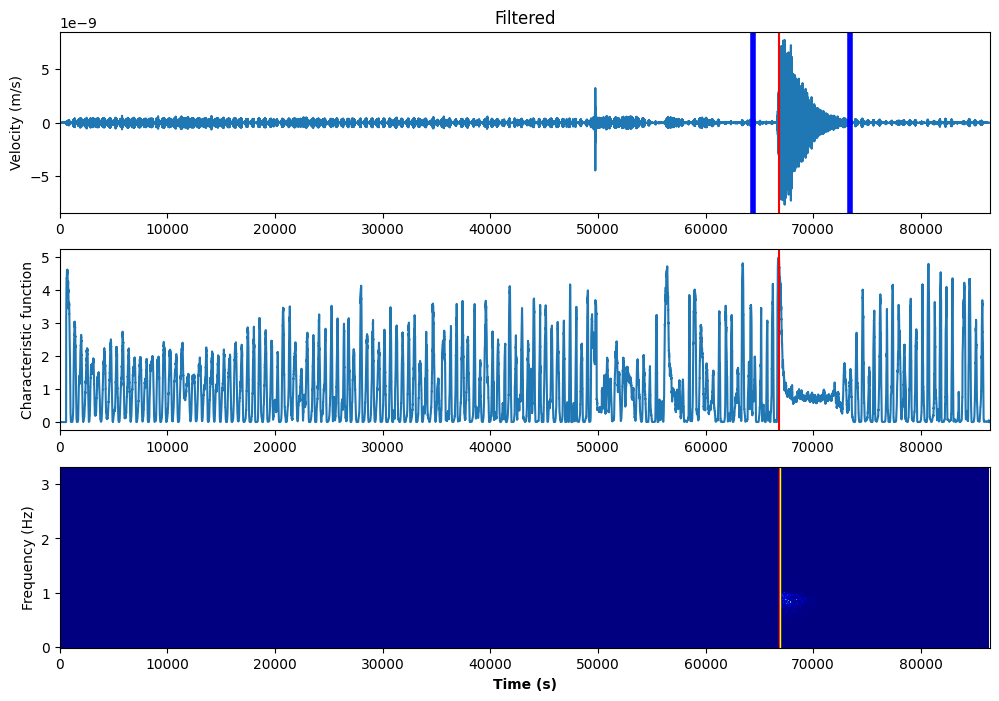

In [41]:
def display_data(df, num_samples=5, rand=True):
    random_rows = df.sample(n=num_samples) if rand else df.sample(n=num_samples, random_state=42)
    for row in random_rows.itertuples():
        swd_centers, tmp_acc = seismic_centers_detect(row.rel_times, row.data, row.sampling_rate, _target=row.target, 
                        _STA=120, _LTA=600, _high_freq_thresh=0.05, _power_thresh=0.4, plot=True)
        
display_data(train_data)